In [1]:
#imports
import numpy as np
import torch
import torch.nn as nn
import pickle
import torchvision
from typing import Union, List, Dict, Any, cast
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Caltech256, CIFAR10, STL10, Caltech101
from torchvision.models import VGG

from torch.nn.parameter import Parameter
from torch.autograd import Function
import torch.nn.functional as F
from matplotlib import pyplot as plt
import multiprocessing as mp


In [2]:
# group norm
def make_gn_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                if norm_layer is None:
                    raise Error("Please specify a norm layer")
                # @group if want to use this, please refer to the higher order function
                # in the next block
                layers += [conv2d, norm_layer(v//2, v)(), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_gn_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_gn_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_gn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_gn_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [3]:
# channel batch
def make_bc_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = WConv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                num_groups = v//2
                eps=1e-08
                layers += [conv2d, BCNorm(v, num_groups, eps), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_bc_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_bc_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_bcwn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_bc_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [4]:
# channel batch
def make_bn_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                eps=1e-08
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_bn_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_bn_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_bn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_bn_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [5]:
# channel batch
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                raise NotImplemented
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_vgg('vgg11', 'A', False, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)


In [6]:
# helper functions
def get_group_norm_layer(in_channel, out_channel):
    def fun():
        return nn.GroupNorm(in_channel, out_channel)
    return fun

# channel norm + weight
# weight
class WConv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(WConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = torch.pow(weight.view(weight.size(0), -1).var(dim=1) + 1e-5, 0.5).view(-1, 1, 1, 1)
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)



class BCNorm(nn.Module):
#     eps = epsilon
    def __init__(self, num_channels, num_groups, eps, estimate=False):
        super(BCNorm, self).__init__()
        self.num_channels = num_channels
        self.num_groups = num_groups
        self.eps = eps
        self.weight = Parameter(torch.ones(1, num_groups, 1))
        self.bias = Parameter(torch.zeros(1, num_groups, 1))
        if estimate:
            self.bn = EstBN(num_channels)
        else:
            self.bn = nn.BatchNorm2d(num_channels)

    def forward(self, inp):
        out = self.bn(inp)
        out = out.view(1, inp.size(0) * self.num_groups, -1)
        out = torch.batch_norm(out, None, None, None, None, True, 0, self.eps, True)
        out = out.view(inp.size(0), self.num_groups, -1)
        out = self.weight * out + self.bias
        out = out.view_as(inp)
        return out
# batch norm


In [7]:
# dataset loading code
class GreyscaleToRGBTransform(object):    
    def __call__(self, image):  
        if image.shape[0] == 1:
            return transforms.Lambda(lambda x: x.repeat(3, 1, 1))(image)
        return image
    
def get_caltech_dataset(batch_size, val_batch_size):
    # only works with Caltech256
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((112, 112)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    # download link is broken
    dataset = Caltech256(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [24486, 6122])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle = True)
    return train_set, val_set

def get_stl_dataset(batch_size, val_batch_size):
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((96, 96)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    dataset = STL10(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [4000, 1000])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers = 4, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, num_workers = 4, shuffle = True)
    return train_set, val_set

def get_cifar_dataset(batch_size, val_batch_size):
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         #GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    dataset = CIFAR10(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers = 4, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, num_workers = 4, shuffle = True)
    return train_set, val_set


In [8]:
def get_model_data(num_classes):
    models = [vgg11_bcwn(num_classes = num_classes), vgg11_gn(norm_layer = get_group_norm_layer, num_classes = num_classes), vgg11_bn(num_classes = num_classes), vgg11(num_classes = num_classes)]
    model_names = ["vgg11_bcwn", "vgg11_gn", "vgg_bn", "vgg_nn"]
    return models, model_names
             
def get_dataset_data(batch_size, val_batch_size):
    datasets = [get_cifar_dataset(batch_size, val_batch_size), get_stl_dataset(batch_size, val_batch_size), get_caltech_dataset(batch_size, val_batch_size)]
    dataset_names = ["CIFAR10", "STL10", "CALTECH256"]
    num_classess = [10, 10, 257]
    return datasets[:1], dataset_names[:1], num_classess[:1]


def train(args, model, device, train_loader, val_loader, optimizer, clip_grad, epoch, save_name):
    model = model.train()
    model = model.to(device)
    train_losses = []
    train_corrects = []
    train_totals = []
    train_percents = []
    val_losses = []
    val_corrects = []
    val_totals = []
    val_percents = []
    
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            target = torch.as_tensor(target) # caltech256 target is int
            data, target = data.to(device), target.to(device)        
            optimizer.zero_grad()
            output = model(data)
            #print(output.shape)
            #print(target.shape)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            loss.backward()
            if clip_grad:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            train_losses.append(loss.item())
            _, train_preds = torch.max(output, 1)
            train_correct = torch.sum(train_preds == target)
            train_total = target.shape[0]
            train_percent = train_correct/train_total
            train_corrects.append(train_correct)
            train_totals.append(train_total)
            train_percents.append(train_percent)
            if batch_idx % args["log_interval"] == 0:
                val_loss, val_correct, val_total =  eval(model, device, val_loader, 4)
                model = model.train()
                optimizer.zero_grad()
                val_losses.append(val_loss)
                val_corrects.append(val_correct)
                val_totals.append(val_total)
                val_percents.append(val_correct/val_total)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\Train_percent: {:.6f}\t ValLoss: {:.6f}, Valpercent: {:.6f}'.format(
                    e, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), train_percent, val_loss.item(), val_correct/val_total))
                if args["dry_run"]:
                    break
        #cache model
        path = "{}_{}.p".format(save_name, e)
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            "loss": train_losses,
            "val_loss": val_losses,
            "train_correct": train_corrects,
            "val_correct": val_corrects,
            "train_total": train_totals,
            "val_total": val_totals,
            "train_percent": train_percents,
            "val_percent": val_percents
            }, path)
        print("saved model state and loss to {}".format(path))

def eval(model, device, val_loader, max_eval):
    model = model.eval()
    model = model.to(device)
    val_losses = []
    val_correct = 0
    val_total = 0
    for batch_idx, (data, target) in enumerate(val_loader):
        target = torch.as_tensor(target)
        data, target = data.to(device), target.to(device)        
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        val_losses.append(loss.item())
        _, val_preds = torch.max(output, 1)
        val_correct += torch.sum(val_preds == target)
        val_total += target.shape[0]
        if max_eval is not None and batch_idx >= max_eval:
            break
    return np.mean(val_losses), val_correct, val_total


In [9]:
def run_tests(args):
    device = torch.device(args["device"])
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        models, model_names = get_model_data(num_classes)
        for model, mn in zip(models, model_names):
            if mn == "vgg_nn":
                clip_grad = True
            else:
                clip_grad = False
            optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
            name = "{}_{}".format(mn, dn)
            trained_model = train(args, model, args["device"], train_set, val_set, optimizer, clip_grad, args["epoch"], name)

def _test_parallel(args, model, mn, dn, train_set, val_set):
    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
    if mn == "vgg_nn":
        clip_grad = True
    else:
        clip_grad = False
    name = "{}_{}".format(mn, dn)
    print("training model {} with {}".format(mn, dn))
    trained_model = train(args, model, args["device"], train_set, val_set, optimizer, clip_grad, args["epoch"], name)
    return name

def _run_test_parallel(args):
    return _test_parallel(*args)

def run_tests_parallel(args):
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        parallel_args = []
        models, model_names = get_model_data(num_classes)
        pool = mp.Pool(4)
        i = 1
        for model, mn in zip(models, model_names):
            args_cur = args.copy()
            args_cur["device"] = "cuda:{}".format(i)
            parallel_args.append((args_cur, model, mn, dn, train_set, val_set))
            i += 2
        print("STARTING {}".format(dn))
        results = pool.imap_unordered(_run_test_parallel, parallel_args)
        for x in results:
            print(x)        
        pool.close()
        
        pool.join()

        print("Finished {}".format(dn))
            

In [10]:
def get_args():
    args = dict()
    args["device"] = "cuda:3" 
    args["lr"] = 1e-4 # learning rate
    args["epoch"] = 10
    args["batch_size"] = 128
    args["val_batch_size"] = 128
    args["log_interval"] = 10
    args["dry_run"] = False
    return args

def main():
    # in theory load from cmd, but ... jupyter
    args = get_args()
    run_tests(args)
    #run_tests_parallel(args)

In [ ]:
main()

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset STL10
    Number of datapoints: 5000
    Root location: ../data
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset Caltech256
    Number of datapoints: 30608
    Root location: ../data/caltech256
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.22

NameError: name 'mnlosses' is not defined

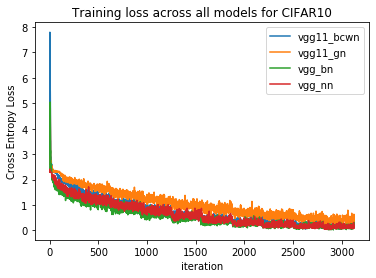

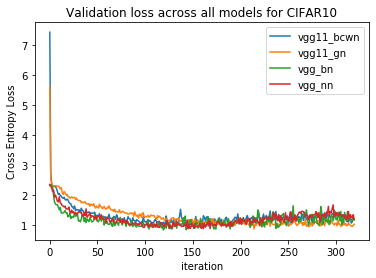

<Figure size 432x288 with 0 Axes>

In [12]:
# plotting code
def plot_losses(dn, mnlosses, title):
    plt.figure()
    for mn, loss in mnlosses:
        plt.plot(loss, label=mn)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("Cross Entropy Loss")
    plt.title(title)
    plt.savefig("../figure/{}.png".format(title))

def plot_accuracy(dn, mnpercents, title):
    plt.figure()
    for mn, accuracy in mnpercents:
        plt.plot(accuracy, label=mn)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("percent")
    plt.title(title)
    plt.savefig("../figure/{}.png".format(title))
    
def plot_all(args, MAX_EPOCH):
    device = torch.device(args["device"])
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    cache_data = dict()
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        models, model_names = get_model_data(num_classes)
        for model, mn in zip(models, model_names):
            if mn == "vgg_nn":
                clip_grad = True
            else:
                clip_grad = False
            optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
            checkpt_name = "{}_{}_{}.p".format(mn, dn, MAX_EPOCH)
            checkpoint = torch.load(checkpt_name)
            model.load_state_dict(checkpoint['model'])
            cache_data[(dn, mn)] = checkpoint
            #plot_train_loss(mn, dn, train_losses)
            #return
    # plot the training loss
    for dn in dataset_names:
        mntlosses = [(mn, cache_data[(dn, mn)]["loss"]) for mn in model_names]
        mnvlosses = [(mn, cache_data[(dn, mn)]["val_loss"]) for mn in model_names]
        mntaccuracy = [(mn, cache_data[(dn, mn)]["train_percent"]) for mn in model_names]
        mnvaccuracy = [(mn, cache_data[(dn, mn)]["val_percent"]) for mn in model_names]
        
        plot_losses(dn, mntlosses, "Training loss across all models for {}".format(dn))
        plot_losses(dn, mnvlosses, "Validation loss across all models for {}".format(dn))
        plot_accuracy(dn, mntlosses, "Training accuracy across all models for {}".format(dn))
        plot_accuracy(dn, mnvlosses, "Validation accuracy across all models for {}".format(dn))
        
    plt.show()
    
plot_all(get_args(), 9)